In [1]:
import os
import cv2
import numpy as np
from numpy import inf
from array2gif import write_gif
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

In [2]:
def imread(path):
    image = cv2.imread(path)
    H, W, C = image.shape
    image_flat = image.reshape(H * W, C)
    return image_flat, H, W


def similarityMatrix(X, r_s=1, r_c=1):  
    n = len(X)
    # S(x) spatial information: coordinate
    S = np.array([[i, j] for i in range(100) for j in range(100)])
    # pdist: Repeatedly compared to find the distance (i -> i+1 distance, i -> i+2 distance, i -> i+3 distance...)
    # squareform: If a condensed distance matrix is passed, a redundant one is returned
    K = squareform(np.exp(-r_s * pdist(S, 'sqeuclidean'))) * squareform(np.exp(-r_c * pdist(X, 'sqeuclidean')))
    
    return K


def clusterColoring(X, K, H, W):
    # define group color
    colordict = {0: [66, 153, 244],
                 1: [234, 67, 53],
                 2: [251, 188, 5],
                 3: [52, 168, 83],
                 4: [127,255,212],
                 }
    temp = np.zeros((H,W,3))
    for h in range(H):
        for w in range(W):
            temp[h,w,:] = colordict[X[h*W+w]]   # 這邊創一個顏色字典來當作每個群的顏色

    return temp.astype(np.uint8)

    
def arr2gif(segments, gif_path):
    for i in range(len(segments)):
        segments[i] = segments[i].transpose(1, 0, 2)
    write_gif(segments, gif_path, fps=10)

![EM](img/kmeansEM.PNG)
reference:k-means++ https://tw511.com/a/01/35682.html

In [3]:
def initial_mean(X, K, initType):
    Cluster = np.zeros((K, X.shape[1]))

    if initType == 'kmeans_pp':
        # pick 1 cluster_mean
        Cluster[0] = X[np.random.randint(low=0, high=X.shape[0], size=1),:]
        # pick k-1 cluster_mean
        for c in range(1, K):
            Dist = np.zeros((len(X), c))
            for i in range(len(X)):
                for j in range(c):
                    Dist[i,j] = np.sqrt(np.sum((X[i] - Cluster[j])**2))
            Dist_min = np.min(Dist, axis=1)
            sum_ = np.sum(Dist_min) * np.random.rand()
            for i in range(len(X)):
                sum_ -= Dist_min[i]
                if sum_ <= 0:
                    Cluster[c] = X[i]
                    break
                    
    else:  #initType == 'random'
        random_pick = np.random.randint(low=0, high=X.shape[0], size=K)
        Cluster = X[random_pick,:]

    
    return Cluster


def kmeans(X, K, H, W, initType='random', gifPath='default.gif'):
    Mean = initial_mean(X, K, initType)

    # Classes of each Xi
    C = np.zeros(len(X), dtype=np.uint8)
    segments = []
    
    EPS = 1e-9
    diff = 1e9
    count = 1
    while diff > EPS :
        # E-step
        for n in range(len(X)):
            dist = []
            for k in range(K):
                dist.append(np.sqrt(np.sum((X[n] - Mean[k]) ** 2)))
            C[n] = np.argmin(dist)    

        # M-step
        New_Mean = np.zeros(Mean.shape)
        for k in range(K):
            class_N = np.argwhere(C == k).reshape(-1)
            for n in class_N:
                New_Mean[k] = New_Mean[k] + X[n]
            if len(class_N) > 0:
                New_Mean[k] = New_Mean[k] / len(class_N)    # standardization

        diff = np.sum((New_Mean - Mean) ** 2)
        Mean = New_Mean

        # cluster Coloring
        segment = clusterColoring(C, K, H, W)
        segments.append(segment)
        
        # plot
        plt.title('iteration={}, diff={}'.format(count, diff))
        plt.imshow(segment)
        plt.show()

        count += 1

    return C, segments


![NandU](img/NandU.PNG)

# main

In [71]:
EPS=1e-9

# set parameters
img_path         = 'image2.png'
k_means_initType = 'kmeans_pp'
type_            = "Normalized"   # Select type
K                = 3                # k clusters

image_flat, Height, Width = imread(img_path)
r_s = 0.001
r_c = 0.001

# similarity matrix
W = similarityMatrix(image_flat, r_s, r_c)

# degree matrix
D = np.diag(np.sum(W, axis=1))

# Unnormalized Laplacian(RatioCut) 
L = D - W

# Normalized Laplacian(NormalizedCut)
D_            = D**(-0.5)
D_[D_ == inf] = 0 
L_sym         = D_@L@D_

<ipython-input-71-559b83c64b2c>:23: RuntimeWarning: divide by zero encountered in power
  D_            = D**(-0.5)


# Select type

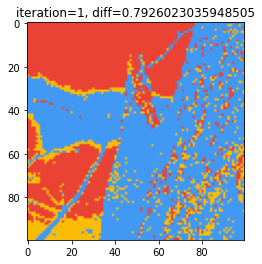

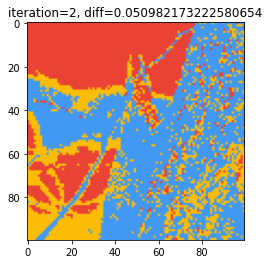

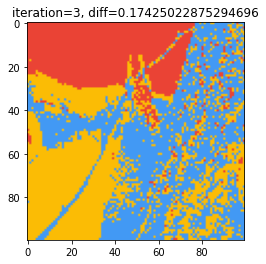

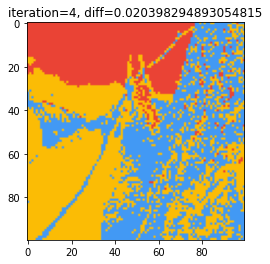

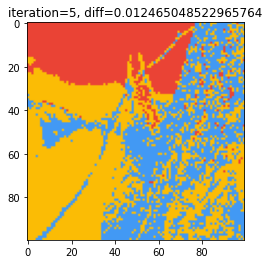

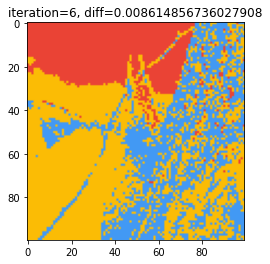

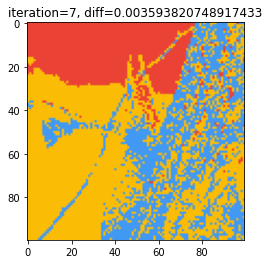

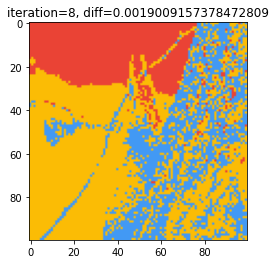

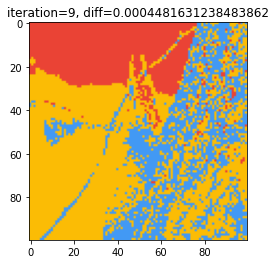

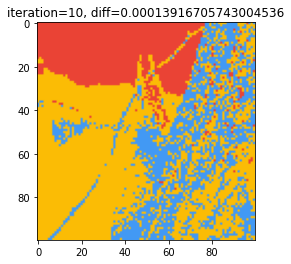

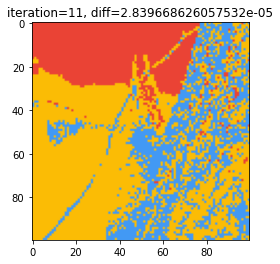

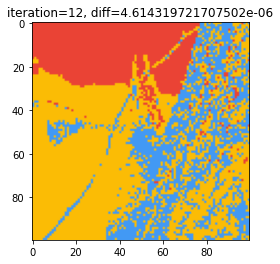

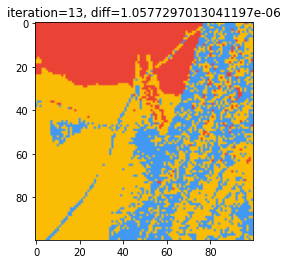

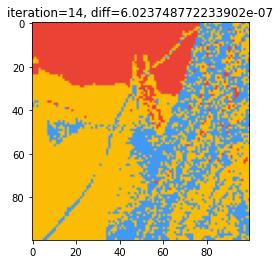

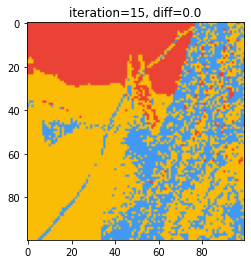

In [72]:
if type_ == "Normalized":
#     # save eigenvalue, eigenvector
#     eigenvalue, eigenvector = np.linalg.eig(L_sym)
#     np.save('npy/{}_{}_eigenvalue_{:.3f}_{:.3f}'.format(type_, img_path.split('.')[0], r_s, r_c), eigenvalue)
#     np.save('npy/{}_{}_eigenvector_{:.3f}_{:.3f}'.format(type_, img_path.split('.')[0], r_s, r_c), eigenvector)

    # load eigenvalue, eigenvector
    eigenvalue = np.load('npy/{}_{}_eigenvalue_{:.3f}_{:.3f}.npy'.format(type_, img_path.split('.')[0], r_s, r_c))
    eigenvector= np.load('npy/{}_{}_eigenvector_{:.3f}_{:.3f}.npy'.format(type_, img_path.split('.')[0], r_s, r_c))
    sort_index = np.argsort(eigenvalue)

    # U:(n,k)
    U = eigenvector[:,sort_index[1:1+K]]
    # T:(n,k) each row with norm 1
    sums = np.sqrt(np.sum(np.square(U), axis=1)).reshape(-1,1)
    T = U / sums

    # k-means
    C, segments = kmeans(T, K, Height, Width, initType=k_means_initType)
    
    # to gif
    gif_path = os.path.join('GIF', '{}_{}_{}_{}Clusters.gif'.format(img_path.split('.')[0], k_means_initType, type_, K))
    arr2gif(segments, gif_path)
    
    
if type_ == "Unnormalized":
#     # save eigenvalue, eigenvector
#     eigenvalue, eigenvector = np.linalg.eig(L)
#     np.save('npy/{}_{}_eigenvalue_{:.3f}_{:.3f}'.format(type_, img_path.split('.')[0], r_s, r_c), eigenvalue)
#     np.save('npy/{}_{}_eigenvector_{:.3f}_{:.3f}'.format(type_, img_path.split('.')[0], r_s, r_c), eigenvector)

    # load eigenvalue, eigenvector
    eigenvalue = np.load('npy/{}_{}_eigenvalue_{:.3f}_{:.3f}.npy'.format(type_, img_path.split('.')[0], r_s, r_c))
    eigenvector= np.load('npy/{}_{}_eigenvector_{:.3f}_{:.3f}.npy'.format(type_, img_path.split('.')[0], r_s, r_c))
    sort_index = np.argsort(eigenvalue)

    # U:(n,k)
    U = eigenvector[:,sort_index[1:1+K]]
    # T:(n,k) each row with norm 1
    sums = np.sqrt(np.sum(np.square(U), axis=1)).reshape(-1,1)
    T = U / sums

    # k-means
    C, segments = kmeans(T, K, Height, Width, initType=k_means_initType)
    
    # gif
    gif_path = os.path.join('GIF', '{}_{}_{}_{}Clusters.gif'.format(img_path.split('.')[0], k_means_initType,type_, K))
    arr2gif(segments, gif_path)

# eigenvector
reference:https://officeguide.cc/python-matplotlib-three-dimensional-plotting-tutorial-examples/

In [69]:
def plot_eigenvector(xs, ys, zs, C):
    fig = plt.figure()
    ax  = fig.gca(projection='3d')
    markers = ['o','*','.']
    for i, marker in enumerate(markers):
        ax.scatter(xs[C==i], ys[C==i], zs[C==i], marker=marker)
    ax.set_title('{}, r_s={}, r_c={}'.format(type_,r_s,r_c))
    plt.show()

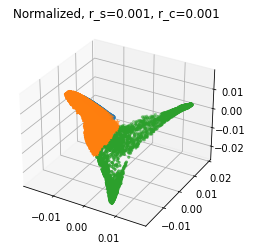

In [70]:
# 3D plot
if K == 3:
    plot_eigenvector(U[:,0], U[:,1], U[:,2], C)

In [ ]:
for angle in range(95, 180, 3):
    ax.view_init(30, angle)
#     filename = "./" + str(angle) + ".png"
#     plt.savefig(filename)
#     print("Save " + filename + " finish")